# ML-Challenge - EURO2024

In [1]:
# ----------------------------------GENERAL---------------------------------

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------VISUALIZATION---------------------------

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# ----------------------------------PRE-PROCESSING---------------------------

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score,classification_report, confusion_matrix

# ----------------------------------PIPELINE AND MODELS----------------------

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Load data

In [4]:
# Teams = pd.read_csv('data/Country_players.csv') # teams composition
# E24 = pd.read_csv('data/Euro_24.csv') # programme matchs de poule
# EHist = pd.read_csv('data/Euros_Data.csv') # historical Data of EUROS
# Players = pd.read_csv('data/male_players.csv') # FIFA individual players attribute
HISTORY = pd.read_csv('data/Matches Data with Rankings.csv') # historical Data of ALL international matches

In [5]:
print(HISTORY.info())
print(HISTORY.head())
print(HISTORY.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   home_team       543 non-null    object 
 1   away_team       543 non-null    object 
 2   home_score      507 non-null    float64
 3   away_score      507 non-null    float64
 4   tournament      543 non-null    object 
 5   city            543 non-null    object 
 6   country         543 non-null    object 
 7   neutral         543 non-null    bool   
 8   winner          507 non-null    object 
 9   year            543 non-null    int64  
 10  rank_home_team  543 non-null    float64
 11  rank_away_team  543 non-null    float64
dtypes: bool(1), float64(4), int64(1), object(6)
memory usage: 47.3+ KB
None
  home_team    away_team  home_score  away_score tournament     city  country  \
0    Poland       Serbia         1.0         0.0   Friendly   Poznań   Poland   
1   Ukraine       Serbia  

home_team          0
away_team          0
home_score        36
away_score        36
tournament         0
city               0
country            0
neutral            0
winner            36
year               0
rank_home_team     0
rank_away_team     0
dtype: int64


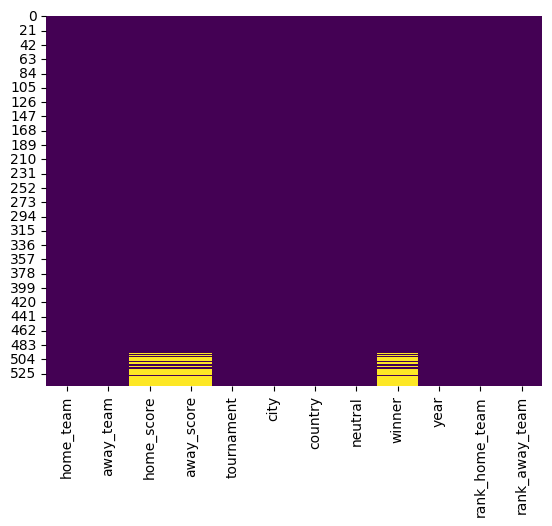

In [6]:
print(HISTORY.isna().sum()) # nb of NAs (or isnull())
# print(HISTORY[HISTORY.isnull().any(axis=1)]) # shows rows with at least one missing value
sns.heatmap(HISTORY.isna(), cbar=False, cmap='viridis'); # Visualize missing values... 

# all the NAs values are the programed Euro 2024 macthes => drop

In [7]:
HISTORY.tail(37)
HISTORY.dropna(inplace=True)
print(HISTORY.isna().sum())

home_team         0
away_team         0
home_score        0
away_score        0
tournament        0
city              0
country           0
neutral           0
winner            0
year              0
rank_home_team    0
rank_away_team    0
dtype: int64


# our target is not "winner" but an "encoded winner", where its Home or Away (or Draw).

In [8]:
HISTORY["Winner_HoAw"] = HISTORY.apply(lambda row: 'Home' if row['winner'] == row['home_team']  else ('Away' if row['winner'] == row['away_team'] else 'Draw'), axis=1)
HISTORY.insert(HISTORY.columns.get_loc('winner') + 1, 'Winner_HoAw', HISTORY.pop('Winner_HoAw'))
HISTORY

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner,Winner_HoAw,year,rank_home_team,rank_away_team
0,Poland,Serbia,1.0,0.0,Friendly,Poznań,Poland,False,Poland,Home,2016,0.505621,-0.939010
1,Ukraine,Serbia,2.0,0.0,Friendly,Kharkiv,Ukraine,False,Ukraine,Home,2016,-0.361158,-0.939010
2,Poland,Netherlands,1.0,2.0,Friendly,Gdańsk,Poland,False,Netherlands,Away,2016,0.505621,0.216695
3,Austria,Netherlands,0.0,2.0,Friendly,Vienna,Austria,False,Netherlands,Away,2016,-0.505621,0.216695
4,England,Netherlands,1.0,2.0,Friendly,London,England,False,Netherlands,Away,2016,0.794547,0.216695
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,Poland,Ukraine,3.0,1.0,Friendly,Warsaw,Poland,False,Poland,Home,2024,-0.361158,0.072232
521,England,Belgium,2.0,2.0,Friendly,London,England,False,Draw,Draw,2024,1.372399,1.516862
524,Germany,Netherlands,2.0,1.0,Friendly,Frankfurt,Germany,False,Germany,Home,2024,0.505621,1.083473
528,Slovenia,Portugal,2.0,0.0,Friendly,Ljubljana,Slovenia,False,Slovenia,Home,2024,-1.372399,1.227936


# Train test split RANDOM, with rankings from corresponding year

In [10]:
# Split data into features and target variable
# we actuall keep very few columns:
X = HISTORY[['home_team','away_team','rank_home_team','rank_away_team']]
Y = HISTORY['Winner_HoAw']

# Split data into training and testing sets, classically 80/20 for classification
from sklearn.model_selection import train_test_split
# stratify = both train and test have the same distributions of the dependent variable, here y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y) 
print("Size of training set:", X_train.shape)
print("Size of test set:", X_test.shape)

Size of training set: (405, 4)
Size of test set: (102, 4)


In [11]:
# Check if train-test split has returned balanced data sets
print('TRAIN DATA:\n',Y_train.value_counts(normalize=True))
print('\nTEST DATA:\n', Y_test.value_counts(normalize=True))


TRAIN DATA:
 Winner_HoAw
Home    0.424691
Away    0.298765
Draw    0.276543
Name: proportion, dtype: float64

TEST DATA:
 Winner_HoAw
Home    0.431373
Away    0.294118
Draw    0.274510
Name: proportion, dtype: float64


In [12]:
X_train.head()

,home_team,away_team,rank_home_team,rank_away_team
478,Spain,Georgia,0.939010,-1.661325
457,Czech Republic,Albania,-0.939010,-1.516862
283,Belgium,Denmark,1.661325,0.650084
206,Denmark,Switzerland,0.216695,0.794547
492,Austria,Turkey,-0.072232,-0.939010


In [13]:
X_train[X_train.isnull().any(axis=1)]

,home_team,away_team,rank_home_team,rank_away_team


In [14]:
Y_train.head()

478    Home
457    Draw
283    Home
206    Home
492    Home
Name: Winner_HoAw, dtype: object

# Auto-ML models with FLAML : with rankings from corresponding year and RANDOM train test split.

In [15]:
from flaml import AutoML

automl = AutoML()

automl_settings = {
    "time_budget": 300, # 5 mins to try and select the best model
    "metric": 'accuracy',
    "task": 'multiclass', # since we have 3 classes
    "log_file_name": 'mylog.log'
}

In [16]:
automl.fit(X_train=X_train, y_train=Y_train.values,
           **automl_settings)

# nearly only uses complex models: List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']

[flaml.automl.logger: 06-13 22:50:49] {1680} INFO - task = multiclass


[flaml.automl.logger: 06-13 22:50:49] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-13 22:50:49] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-13 22:50:49] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 06-13 22:50:49] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-13 22:50:49] {2345} INFO - Estimated sufficient time budget=2480s. Estimated necessary time budget=61s.
[flaml.automl.logger: 06-13 22:50:49] {2392} INFO -  at 0.6s,	estimator lgbm's best error=0.5605,	best estimator lgbm's best error=0.5605
[flaml.automl.logger: 06-13 22:50:49] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-13 22:50:50] {2392} INFO -  at 0.8s,	estimator lgbm's best error=0.5605,	best estimator lgbm's best error=0.5605
[flaml.automl.logger: 06-13 22:50:50] {2219} INFO - iteration 2, current learner lgbm
[flaml.aut

In [18]:
automl

AutoML(append_log=False, auto_augment=True, custom_hp={},
       cv_score_agg_func=None, early_stop=False, ensemble=False,
       estimator_list='auto', eval_method='auto', fit_kwargs_by_estimator={},
       force_cancel=False, free_mem_ratio=0, hpo_method='auto',
       keep_search_state=False, learner_selector='sample', log_file_name='',
       log_training_metric=False, log_type='better', max_iter=None,
       mem_thres=4294967296, metric='auto', metric_constraints=[],
       min_sample_size=10000, mlflow_logging=True, model_history=False,
       n_concurrent_trials=1, n_jobs=-1, n_splits=5, pred_time_limit=inf,
       preserve_checkpoint=True, retrain_full=True, ...)

In [19]:
print('automl.best_estimator: \n-----------\n',automl.best_estimator)
print('\nautoml.best_config: \n-----------\n',automl.best_config)
print('\nautoml.model.get_params: \n-----------\n',automl.model.get_params())


automl.best_estimator: 
-----------
 rf

automl.best_config: 
-----------
 {'n_estimators': 4, 'max_features': 0.5158878187053114, 'max_leaves': 4, 'criterion': 'entropy'}

automl.model.get_params: 
-----------
 {'n_estimators': 4, 'max_features': 0.5158878187053114, 'criterion': 'entropy', 'n_jobs': -1, 'max_leaf_nodes': 4, 'random_state': 12032022, 'verbose': 0, 'task': <flaml.automl.task.generic_task.GenericTask object at 0x000002725B35F8E0>, '_estimator_type': 'classifier'}


### export the model

In [21]:
import pickle

# Assuming 'automl' is your fitted AutoML instance
MODEL_perYEARrankings_RF = automl
# Serialize the model to a file
with open('MODEL_perYEARrankings_RF.pkl', 'wb') as f:
    pickle.dump(MODEL_perYEARrankings_RF, f)

### Reusing the Model

              precision    recall  f1-score   support

        Away       0.50      0.37      0.42        30
        Draw       0.33      0.07      0.12        28
        Home       0.50      0.84      0.63        44

    accuracy                           0.49       102
   macro avg       0.44      0.43      0.39       102
weighted avg       0.45      0.49      0.43       102



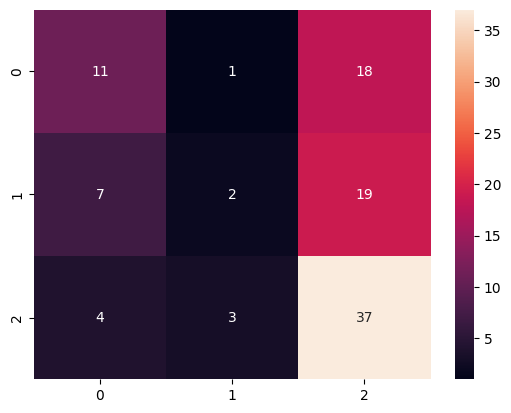

In [22]:
# Load the saved model
with open('MODEL_perYEARrankings_RF.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
# and predict:
predictions = loaded_model.predict(X_test)
cf = confusion_matrix(Y_test, predictions)
print(classification_report(Y_test, predictions))
sns.heatmap(cf, annot=True);
# attention, now it's a random forest, not xgboost. But the accuracy is better (0.49)

# Train test split for Euro 2020 with data from pre-2020

In [23]:
HISTORY['tournament'].unique()

array(['Friendly', 'UEFA Euro', 'FIFA World Cup qualification',
       'UEFA Nations League', 'FIFA World Cup', 'UEFA Euro qualification'],
      dtype=object)

In [24]:
# Split data into features and target variable
# EURO 2020 took place in 2021 !
TRAIN = HISTORY[(HISTORY['year']<=2021)&(HISTORY['tournament']!='UEFA Euro')]  # train  = all data from 2016 until 2021 WITHOUT Euro from 2021
TEST = HISTORY[(HISTORY['year']==2021)&(HISTORY['tournament']=='UEFA Euro')] # test  = only Euro from 2021
# this code (selection) was checked in an eralier version to see if it's returning the rights rows: all good.

X_train = TRAIN[['home_team','away_team','rank_home_team','rank_away_team']]
Y_train = TRAIN['Winner_HoAw']
X_test = TEST[['home_team','away_team','rank_home_team','rank_away_team']]
Y_test = TEST['Winner_HoAw']

print("Size of training set:", X_train.shape)
print("Size of test set:", X_test.shape)

Size of training set: (310, 4)
Size of test set: (35, 4)


# FLAML for EURO 2021 data

In [25]:
from flaml import AutoML

automl_EURO2021 = AutoML()

automl_EURO2021_settings = {
    "time_budget": 300, # 5 mins to try and select the best model
    "metric": 'accuracy',
    "task": 'multiclass', # since we have 3 classes
    "log_file_name": 'mylog.log'
}

In [26]:
automl_EURO2021.fit(X_train=X_train, y_train=Y_train.values,
           **automl_settings)

[flaml.automl.logger: 06-13 23:03:08] {1680} INFO - task = multiclass
[flaml.automl.logger: 06-13 23:03:08] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-13 23:03:08] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-13 23:03:08] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 06-13 23:03:08] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-13 23:03:08] {2345} INFO - Estimated sufficient time budget=2138s. Estimated necessary time budget=52s.
[flaml.automl.logger: 06-13 23:03:08] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.5516,	best estimator lgbm's best error=0.5516
[flaml.automl.logger: 06-13 23:03:08] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-13 23:03:09] {2392} INFO -  at 0.5s,	estimator lgbm's best error=0.5516,	best estimator lgbm's best error=0.5516
[flaml.automl.logger: 06-1

In [27]:
print('automl_EURO2021.best_estimator: \n-----------\n',automl_EURO2021.best_estimator)
print('\nautoml_EURO2021.best_config: \n-----------\n',automl_EURO2021.best_config)
print('\nautoml_EURO2021.model.get_params: \n-----------\n',automl_EURO2021.model.get_params())

automl_EURO2021.best_estimator: 
-----------
 xgb_limitdepth

automl_EURO2021.best_config: 
-----------
 {'n_estimators': 14, 'max_depth': 7, 'min_child_weight': 23.183081701250526, 'learning_rate': 1.0, 'subsample': 0.9199463090949461, 'colsample_bylevel': 0.937058194690618, 'colsample_bytree': 0.8979257784585539, 'reg_alpha': 0.040147992708804786, 'reg_lambda': 3.630321382080707}

automl_EURO2021.model.get_params: 
-----------
 {'n_estimators': 14, 'max_depth': 7, 'min_child_weight': 23.183081701250526, 'learning_rate': 1.0, 'subsample': 0.9199463090949461, 'colsample_bylevel': 0.937058194690618, 'colsample_bytree': 0.8979257784585539, 'reg_alpha': 0.040147992708804786, 'reg_lambda': 3.630321382080707, 'n_jobs': -1, 'verbosity': 0, 'task': <flaml.automl.task.generic_task.GenericTask object at 0x000002725D374D30>, '_estimator_type': 'classifier'}


In [28]:
import pickle
# EXPORT MODEL
# Assuming 'automl' is your fitted AutoML instance
MODEL_perYEARrankings_EURO2021_xgb_limitdepth = automl_EURO2021
# Serialize the model to a file
with open('MODEL_perYEARrankings_EURO2021_xgb_limitdepth.pkl', 'wb') as f:
    pickle.dump(MODEL_perYEARrankings_EURO2021_xgb_limitdepth, f)

              precision    recall  f1-score   support

        Away       0.71      0.42      0.53        12
        Draw       0.17      0.10      0.12        10
        Home       0.45      0.77      0.57        13

    accuracy                           0.46        35
   macro avg       0.45      0.43      0.41        35
weighted avg       0.46      0.46      0.43        35



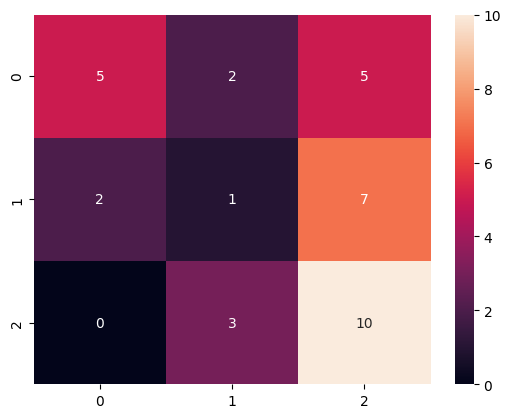

In [29]:
# Load the saved model
with open('MODEL_perYEARrankings_EURO2021_xgb_limitdepth.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
# and predict:
predictions = loaded_model.predict(X_test)
cf = confusion_matrix(Y_test, predictions)
print(classification_report(Y_test, predictions))
sns.heatmap(cf, annot=True);

# TRY A PREDICTION

In [30]:
# power rankings, to add the rank to the teams which are guessed.
# rankings are SCALED = comparable to what we have in the model...
ranking = pd.read_csv('data/scaled_power_rankings_2016-2024_updated.csv')


# Guess:
Away = 'Albania'
Home = 'Germany'

GUESS = pd.DataFrame({
    'home_team': [Home],
    'away_team': [Away],
    'rank_home_team': [ float(ranking[ranking['Country']==Home]['2024']) ],
    'rank_away_team': [ float(ranking[ranking['Country']==Away]['2024']) ]
})
GUESS


,home_team,away_team,rank_home_team,rank_away_team
0,Germany,Albania,0.505621,-1.516862


In [31]:
# Load the saved model
with open('MODEL_perYEARrankings_RF.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
# and predict:
RESULT = loaded_model.predict(GUESS)
if RESULT == 'Home':
    print('Predicted winner is: ', Home)
elif RESULT == 'Away':
    print('Predicted winner is: ', Away)
else: print('It is a DRAW !')

Predicted winner is:  Germany


In [32]:
loaded_model.best_estimator

'rf'

# PREDICTIONS for ALL GROUP GAMES

In [33]:
euro_24_predictions = pd.read_csv('data/euro_24_predictions.csv')
euro_24_predictions.drop(columns='Group', inplace=True)
euro_24_predictions.columns = euro_24_predictions.columns.str.lower()
euro_24_predictions = euro_24_predictions.rename(columns={'home_team_rank': 'rank_home_team' , 'away_team_rank': 'rank_away_team' })
euro_24_predictions

,home_team,away_team,rank_home_team,rank_away_team
0,Germany,Scotland,0.505621,-0.794547
1,Germany,Hungary,0.505621,-0.216695
2,Scotland,Hungary,-0.794547,-0.216695
3,Hungary,Switzerland,-0.216695,0.361158
4,Scotland,Switzerland,-0.794547,0.361158
5,Switzerland,Germany,0.361158,0.505621
6,Spain,Croatia,0.939010,0.650084
7,Spain,Italy,0.939010,0.794547
8,Croatia,Italy,0.650084,0.794547
9,Italy,Albania,0.794547,-1.516862


In [38]:
# Load the saved model
with open('MODEL_perYEARrankings_RF.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
print('MODEL :',loaded_model.best_estimator)
# and predict:
predictions = loaded_model.predict(euro_24_predictions)
prediction_confidence  = loaded_model.predict_proba(euro_24_predictions)
#include this to euro_24_predictions
euro_24_predictions['Winner'] = predictions
euro_24_predictions['Confidence Max'] = prediction_confidence.max(axis=1)
euro_24_predictions['Confidence Min'] = prediction_confidence.min(axis=1)
# export
euro_24_predictions.to_csv('euro_24_predictions_MODEL=RF.csv', index=False)
# display
euro_24_predictions

MODEL : rf


,home_team,away_team,rank_home_team,rank_away_team,Winner,Confidence Max,Confidence Min
0,Germany,Scotland,0.505621,-0.794547,Home,0.589698,0.184519
1,Germany,Hungary,0.505621,-0.216695,Home,0.438665,0.244733
2,Scotland,Hungary,-0.794547,-0.216695,Home,0.380412,0.252015
3,Hungary,Switzerland,-0.216695,0.361158,Draw,0.371036,0.275203
4,Scotland,Switzerland,-0.794547,0.361158,Draw,0.371036,0.275203
5,Switzerland,Germany,0.361158,0.505621,Away,0.372531,0.308417
6,Spain,Croatia,0.939010,0.650084,Home,0.410644,0.283320
7,Spain,Italy,0.939010,0.794547,Away,0.372531,0.308417
8,Croatia,Italy,0.650084,0.794547,Home,0.396355,0.270104
9,Italy,Albania,0.794547,-1.516862,Home,0.658515,0.169593


# END